


## Problem Setup
This example demonstrates a multi-agent deep deterministic policy gradient (MADDPG) approach to a competitive environment where chasers aim to catch evaders. Each group of agents (chasers and evaders) has its own policy and value networks, trained either independently or in a mixed cooperative-competitive setting. It serves as our control when we try and integrate prospect theory into the policy gradient, seeing if we can get different results than the reward graphs below. Code is based from [https://pytorch.org/rl/0.6/tutorials/multiagent_competitive_ddpg.html]

## Clear Problem Statement
Train two chaser agents to minimize the evader’s cumulative reward while simultaneously training the evader agent to maximize its own cumulative reward. The environment runs for a fixed number of steps, and training can be halted for certain agents at a chosen iteration.

## Mathematical Formulation
- **Agent Policies**: $\pi_i(\mathbf{o_i}; \theta_i)$ map observations $\mathbf{o_i}$ to continuous actions.
- **Value Function**: $Q_i(\mathbf{o}, \mathbf{a}; \phi_i)$ estimates future return given all agents’ actions $\mathbf{a}$ and observations $\mathbf{o}$.
- **Loss Functions**: DDPG losses incorporate actor and critic objectives, ensuring that each agent maximizes expected returns while considering centralized training and decentralized execution.
- **Updates**: Soft updates are performed on target networks with \(\tau\) for both the policy and value functions.

## Data Requirements
- Episodes of agent interactions, collected with exploration strategies (e.g., Gaussian noise).
- Replay buffers per group for sampled training batches containing states, actions, rewards, and next states.

## Success Metrics
- Mean episode reward for each group (chasers and evaders), typically measured and plotted over training iterations.
- Convergence or stabilization of the reward signal, indicating improved policy performance.


In [ ]:
!pip3 install torchrl==0.6.0
!pip3 install vmas
!pip3 install pettingzoo[mpe]==1.24.3
!pip3 install tqdm

  Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached triton-3.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.4 kB)
Using cached torch-2.6.0-cp311-cp311-manylinux1_x86_64.whl (766.7 MB)
Using cached triton-3.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (253.2 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.
torchvision 0.20.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is 

### **Approach: Importing Required Libraries**
This section imports essential modules for implementing MADDPG:  
- **PyTorch** for deep learning operations.  
- **`torchrl` modules** for multi-agent reinforcement learning, including environments, policies, collectors, and replay buffers.  
- **`tensordict`** for structured tensor operations.  
- **Matplotlib** for visualization.  
- **`tqdm`** for progress tracking.

In [ ]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase, is_tensor_collection

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False


try:
    from torch.compiler import is_compiling
except ImportError:
    from torch._dynamo import is_compiling

/usr/local/lib/python3.11/dist-packages/torchrl/data/replay_buffers/samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [ ]:
import torchrl

print(torchrl.__version__)

0.6.0


### **Approach: Environment Setup & Hyperparameters**
- **Seed & Device**: Sets the random seed for reproducibility and selects the appropriate device (GPU if available, otherwise CPU).  
- **Sampling**: Defines frames collected per batch (`1,000`), total iterations (`50`), and total frames (`50,000`).  
- **Training Control**: Stops evader training at `iteration_when_stop_training_evaders = 25`.  
- **Replay Buffer**: Stores up to `1M` frames for experience replay.  
- **Training Parameters**:  
  - **Optimization**: `100` updates per iteration, batch size of `128`.  
  - **Learning Rate**: `3e-4`, gradient clipping at `1.0`.  
- **DDPG-Specific**: Uses discount factor (`γ = 0.99`) and soft update parameter (`τ = 0.005`).

In [ ]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
n_iters = 100  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# We will stop training the evaders after this many iterations,
# should be 0 <= iteration_when_stop_training_evaders <= n_iters
iteration_when_stop_training_evaders = n_iters // 2

# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of the target network

### **Approach: Environment Configuration**
- **Max Steps**: Each episode runs for `100` steps.  
- **Agents & Obstacles**: `2` chasers, `1` evader, and `2` obstacles.  
- **VMAS for Performance**:  
  - If `use_vmas = True`, uses `VmasEnv` for efficient vectorized multi-agent simulation.  
  - Otherwise, defaults to `PettingZooEnv` (parallel mode) for `simple_tag_v3`.  
- **Vectorization**: `num_vmas_envs = frames_per_batch / max_steps` ensures efficient frame collection.

In [ ]:
max_steps = 100  # Environment steps before done

n_chasers = 2
n_evaders = 1
n_obstacles = 5

use_vmas = True  # Set this to True for a great performance speedup

if not use_vmas:
    base_env = PettingZooEnv(
        task="simple_tag_v3",
        parallel=True,  # Use the Parallel version
        seed=seed,
        # Scenario specific
        continuous_actions=True,
        num_good=n_evaders,
        num_adversaries=n_chasers,
        num_obstacles=n_obstacles,
        max_cycles=max_steps,
    )
else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )  # Number of vectorized environments. frames_per_batch collection will be divided among these environments
    base_env = VmasEnv(
        scenario="simple_tag",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        device=device,
        seed=seed,
        # Scenario specific
        num_good_agents=n_evaders,
        num_adversaries=n_chasers,
        num_landmarks=n_obstacles,
    )

In [ ]:
print(f"group_map: {base_env.group_map}")

group_map: {'adversary': ['adversary_0', 'adversary_1'], 'agent': ['agent_0']}


In [ ]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    adversary: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([10, 2])),
    agent: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 1, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 1, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cu

In [ ]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('adversary', 'action'), ('agent', 'action')]
reward_keys: [('adversary', 'reward'), ('agent', 'reward')]
done_keys: ['done', 'terminated']


### **Approach: Environment Transformation**
- **Wraps `base_env` with `TransformedEnv`** to apply reward processing.  
- **`RewardSum` Aggregation**:  
  - Uses `reward_keys` from `base_env` to sum rewards over time.  
  - Resets rewards using `_reset` keys for each agent group.  
- **Purpose**: Ensures proper reward tracking across multi-agent interactions.

In [ ]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

In [ ]:
check_env_specs(env)

2025-03-02 03:20:43,305 [torchrl][INFO] check_env_specs succeeded!


In [ ]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 2, 20]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 5, 2]),
            device=cuda:0,
            is_shared=True),
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 1, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 1, 18]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_si

### **Approach: Policy Network Setup**
- **Iterates over agent groups** to create independent policies.  
- **Defines `MultiAgentMLP`** for decentralized policies:
  - **Observations & Actions**: Uses `env.observation_spec` and `env.full_action_spec`.
  - **Decentralized Execution**: Each agent acts based on its local observation.
  - **Parameter Sharing**: Controlled by `share_parameters_policy` (set to `True` for efficiency).
  - **Architecture**: 2-layer MLP (`256` neurons per layer, `Tanh` activation).
- **Wraps in `TensorDictModule`**:
  - Reads observations from `TensorDict` and writes action parameters.  
  - Allows structured tensor operations for multi-agent training.

In [ ]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = True  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

### **Approach: Probabilistic Policy Definition**
- **Wraps policy networks (`policy_modules`) in `ProbabilisticActor`** to handle stochastic action sampling.  
- **Uses `TanhDelta` Distribution**:
  - Ensures continuous action outputs stay within predefined bounds (`low`, `high`).  
  - Helps stabilize training by keeping actions constrained.  
- **Input & Output Keys**:
  - Reads action parameters from `policy_modules` (`(group, "param")`).  
  - Outputs final actions (`(group, "action")`).  
- **Log Probabilities Disabled (`return_log_prob=False`)**:  
  - Not needed for deterministic policy updates in DDPG.

In [ ]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low,
            "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

### **Approach: Exploration Policy with Gaussian Noise**
- **Adds exploration noise to deterministic policies** using `AdditiveGaussianModule`.  
- **Purpose**: Encourages better exploration by injecting Gaussian noise into actions.  
- **Annealing Strategy**:
  - **Starts with `sigma_init = 0.9`** (high noise for exploration).  
  - **Decays to `sigma_end = 0.1`** over `total_frames / 2` steps, reducing noise gradually.  
- **Wrapped in `TensorDictSequential`**:
  - First applies the base policy (`policies[group]`).  
  - Then adds Gaussian noise to the output action (`(group, "action")`).  
- **Ensures Smooth Transition**: High exploration at the start, stabilizing towards exploitation.

In [ ]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

### **Approach: Critic Network for Value Estimation**
- **Defines critic networks for each agent group** to estimate state-action values (\(Q\)-values).  
- **Centralized vs. Decentralized Critic**:
  - **`MADDPG = True`**: Uses a centralized critic (multi-agent).  
  - **`IDDPG = False`**: Uses an independent critic per agent.  
- **Feature Concatenation (`cat_module`)**:
  - Combines agent's observation and action into a single tensor (`(group, "obs_action")`).  
- **Critic Network (`critic_module`)**:
  - Takes concatenated state-action inputs and predicts a **single Q-value per agent**.  
  - Uses a **2-layer MLP (256 neurons per layer, `Tanh` activation)**.  
  - Supports parameter sharing (`share_parameters_critic = True`).  
- **Final Critic Pipeline (`TensorDictSequential`)**:
  - First applies **feature concatenation (`cat_module`)**.  
  - Then passes through **`MultiAgentMLP` for value estimation** (`(group, "state_action_value")`).

In [ ]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

In [ ]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )

Running value and policy for group 'adversary': TensorDict(
    fields={
        adversary: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                obs_action: Tensor(shape=torch.Size([10, 2, 22]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 2, 20]), device=cuda:0, dtype=torch.float32, is_shared=True),
                param: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                state_action_value: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 2]),
            device=cuda:0,
            is_shared=True),
        agent: TensorDict(
            fields={
            

### **Approach: Data Collection for Training**
- **Combines all group exploration policies** into a single sequential module (`TensorDictSequential`), ensuring actions include exploration noise.  
- **`SyncDataCollector` for Data Sampling**:
  - Collects experience from the environment using **exploration policies**.  
  - Runs on **`device` (GPU or CPU)** for efficiency.  
  - **Frames per batch**: `1,000`, ensuring large enough updates per iteration.  
  - **Total frames**: `50,000` (over `50` iterations).  
- **Purpose**: Efficiently gathers on-policy experiences for training with replay buffers.

In [ ]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [ ]:
#Standard in off policy algos for efficient data collections
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(memory_size, device="cpu"),
        sampler=RandomSampler(),
        batch_size=train_batch_size,
    )
    replay_buffer.append_transform(lambda batch: batch.to("cuda:0"))
    replay_buffers[group] = replay_buffer

### **Approach: Loss Calculation & Optimization**
#### **Defining the Loss Function (`DDPGLoss`)**
- **Uses separate actor and critic losses**:
  - **`actor_network = policies[group]`**: Optimizes agent actions.
  - **`value_network = critics[group]`**: Estimates state-action values.
- **Target Network (`delay_value = True`)**:
  - Uses a **target critic** for more stable learning.
  - **Loss function**: Mean Squared Error (`"l2"`).
- **Key Assignments**:
  - **State-action value**: `(group, "state_action_value")`.
  - **Reward Signal**: `(group, "reward")`.
  - **Termination Handling**: `(group, "done")` and `(group, "terminated")`.
- **TD(0) Estimator**: Uses **Temporal Difference (TD) learning** with discount factor `γ = 0.99`.

#### **Target Network Updates**
- **Soft update mechanism (`SoftUpdate`)**:
  - **Gradually updates target networks** using `τ = 0.005`.
  - Prevents drastic changes, improving stability.

#### **Optimizers**
- **Separate Adam optimizers for actor and critic networks**:
  - **`loss_actor`**: Updates policy parameters.
  - **`loss_value`**: Updates value network parameters.
- **Learning rate (`lr = 3e-4`)** ensures smooth gradient updates.

In [ ]:
w_plus_prime_const = 0.2
w_minus_prime_const = 0.8

def u_plus(x):
    alpha = 0.88
    return torch.pow(x, alpha)

def u_minus(x):
    alpha = 0.88
    lam = 2.25
    return lam * torch.pow(-x, alpha)

def w_plus_prime(p):
    eta = 0.61
    return eta * torch.pow(p, eta - 1)

def w_minus_prime(p):
    eta = 0.69
    return eta * torch.pow(p, eta - 1)

def compute_phi_linear(R):
    """
    Compute linearized CPT sensitivity:
    φ(R) ≈ w'_+(p*) * u^+(R) for R>=0, and -w'_-(p*) * u^-(R) for R<0.
    """
    R = R.view(-1)
    v = torch.where(R >= 0, u_plus(R), -u_minus(R))
    phi = torch.where(R >= 0, w_plus_prime_const * v, -w_minus_prime_const * v)
    return phi.mean()

def C_transform(x):
    """
    Simple CPT transformation on one-step return:
    C(x) ≈ w'_+(p*) * u^+(x) if x >= 0, else -w'_-(p*) * u^-(x).
    """
    return torch.where(x >= 0, w_plus_prime_const * u_plus(x), -w_minus_prime_const * u_minus(x))

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from typing import Tuple

import torch
from tensordict import TensorDict, TensorDictBase, TensorDictParams
from tensordict.nn import dispatch, TensorDictModule

from tensordict.utils import NestedKey, unravel_key
from torchrl.modules.tensordict_module.actors import ActorCriticWrapper
from torchrl.objectives.common import LossModule
from torchrl.objectives.utils import (
    _cache_values,
    _GAMMA_LMBDA_DEPREC_ERROR,
    _reduce,
    default_value_kwargs,
    distance_loss,
    ValueEstimators,
)
from torchrl.objectives.value import TD0Estimator, TD1Estimator, TDLambdaEstimator


class CPTDDPGLoss(LossModule):
    """The DDPG Loss class.

    Args:
        actor_network (TensorDictModule): a policy operator.
        value_network (TensorDictModule): a Q value operator.
        loss_function (str): loss function for the value discrepancy. Can be one of "l1", "l2" or "smooth_l1".
        delay_actor (bool, optional): whether to separate the target actor networks from the actor networks used for
            data collection. Default is ``False``.
        delay_value (bool, optional): whether to separate the target value networks from the value networks used for
            data collection. Default is ``True``.
        separate_losses (bool, optional): if ``True``, shared parameters between
            policy and critic will only be trained on the policy loss.
            Defaults to ``False``, i.e., gradients are propagated to shared
            parameters for both policy and critic losses.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``"none"`` | ``"mean"`` | ``"sum"``. ``"none"``: no reduction will be applied,
            ``"mean"``: the sum of the output will be divided by the number of
            elements in the output, ``"sum"``: the output will be summed. Default: ``"mean"``.

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> from tensordict import TensorDict
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> batch = [2, ]
        >>> data = TensorDict({
        ...        "observation": torch.randn(*batch, n_obs),
        ...        "action": spec.rand(batch),
        ...        ("next", "done"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "terminated"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "reward"): torch.randn(*batch, 1),
        ...        ("next", "observation"): torch.randn(*batch, n_obs),
        ...    }, batch)
        >>> loss(data)
        TensorDict(
            fields={
                loss_actor: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                loss_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)

    This class is compatible with non-tensordict based modules too and can be
    used without recurring to any tensordict-related primitive. In this case,
    the expected keyword arguments are:
    ``["next_reward", "next_done", "next_terminated"]`` + in_keys of the actor_network and value_network.
    The return value is a tuple of tensors in the following order:
    ``["loss_actor", "loss_value", "pred_value", "target_value", "pred_value_max", "target_value_max"]``

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> _ = torch.manual_seed(42)
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> loss_actor, loss_value, pred_value, target_value, pred_value_max, target_value_max = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    The output keys can also be filtered using the :meth:`DDPGLoss.select_out_keys`
    method.

    Examples:
        >>> loss.select_out_keys('loss_actor', 'loss_value')
        >>> loss_actor, loss_value = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    """

    @dataclass
    class _AcceptedKeys:
        """Maintains default values for all configurable tensordict keys.

        This class defines which tensordict keys can be set using '.set_keys(key_name=key_value)' and their
        default values.

        Attributes:
            state_action_value (NestedKey): The input tensordict key where the
                state action value is expected. Will be used for the underlying
                value estimator as value key. Defaults to ``"state_action_value"``.
            priority (NestedKey): The input tensordict key where the target
                priority is written to. Defaults to ``"td_error"``.
            reward (NestedKey): The input tensordict key where the reward is expected.
                Will be used for the underlying value estimator. Defaults to ``"reward"``.
            done (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is done. Will be used for the underlying value estimator.
                Defaults to ``"done"``.
            terminated (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is terminated. Will be used for the underlying value estimator.
                Defaults to ``"terminated"``.

        """

        state_action_value: NestedKey = "state_action_value"
        priority: NestedKey = "td_error"
        reward: NestedKey = "reward"
        done: NestedKey = "done"
        terminated: NestedKey = "terminated"

    tensor_keys: _AcceptedKeys
    default_keys = _AcceptedKeys
    default_value_estimator: ValueEstimators = ValueEstimators.TD0
    out_keys = [
        "loss_actor",
        "loss_value",
        "pred_value",
        "target_value",
        "pred_value_max",
        "target_value_max",
    ]

    actor_network: TensorDictModule
    value_network: actor_network
    actor_network_params: TensorDictParams
    value_network_params: TensorDictParams
    target_actor_network_params: TensorDictParams
    target_value_network_params: TensorDictParams

    def __init__(
        self,
        actor_network: TensorDictModule,
        value_network: TensorDictModule,
        *,
        loss_function: str = "l2",
        delay_actor: bool = False,
        delay_value: bool = True,
        gamma: float = None,
        separate_losses: bool = False,
        reduction: str = None,
    ) -> None:
        self._in_keys = None
        if reduction is None:
            reduction = "mean"
        super().__init__()
        self.delay_actor = delay_actor
        self.delay_value = delay_value

        actor_critic = ActorCriticWrapper(actor_network, value_network)
        params = TensorDict.from_module(actor_critic)
        params_meta = params.apply(
            self._make_meta_params, device=torch.device("meta"), filter_empty=False
        )
        with params_meta.to_module(actor_critic):
            self.__dict__["actor_critic"] = deepcopy(actor_critic)

        self.convert_to_functional(
            actor_network,
            "actor_network",
            create_target_params=self.delay_actor,
        )
        if separate_losses:
            # we want to make sure there are no duplicates in the params: the
            # params of critic must be refs to actor if they're shared
            policy_params = list(actor_network.parameters())
        else:
            policy_params = None
        self.convert_to_functional(
            value_network,
            "value_network",
            create_target_params=self.delay_value,
            compare_against=policy_params,
        )
        self.actor_critic.module[0] = self.actor_network
        self.actor_critic.module[1] = self.value_network

        self.actor_in_keys = actor_network.in_keys
        self.value_exclusive_keys = set(self.value_network.in_keys) - (
            set(self.actor_in_keys) | set(self.actor_network.out_keys)
        )

        self.loss_function = loss_function
        self.reduction = reduction
        if gamma is not None:
            raise TypeError(_GAMMA_LMBDA_DEPREC_ERROR)

    def _forward_value_estimator_keys(self, **kwargs) -> None:
        if self._value_estimator is not None:
            self._value_estimator.set_keys(
                value=self._tensor_keys.state_action_value,
                reward=self._tensor_keys.reward,
                done=self._tensor_keys.done,
                terminated=self._tensor_keys.terminated,
            )
        self._set_in_keys()

    def _set_in_keys(self):
        in_keys = {
            unravel_key(("next", self.tensor_keys.reward)),
            unravel_key(("next", self.tensor_keys.done)),
            unravel_key(("next", self.tensor_keys.terminated)),
            *self.actor_in_keys,
            *[unravel_key(("next", key)) for key in self.actor_in_keys],
            *self.value_network.in_keys,
            *[unravel_key(("next", key)) for key in self.value_network.in_keys],
        }
        self._in_keys = sorted(in_keys, key=str)

    @property
    def in_keys(self):
        if self._in_keys is None:
            self._set_in_keys()
        return self._in_keys

    @in_keys.setter
    def in_keys(self, values):
        self._in_keys = values


    def _clear_weakrefs(self, *tds):
        if is_compiling():
            # Waiting for weakrefs reconstruct to be supported by compile
            for td in tds:
                if isinstance(td, str):
                    td = getattr(self, td, None)
                if not is_tensor_collection(td):
                    continue
                td.clear_refs_for_compile_()

    @dispatch
    def forward(self, tensordict: TensorDictBase) -> TensorDict:
        """Computes the DDPG losses given a tensordict sampled from the replay buffer.

        This function will also write a "td_error" key that can be used by prioritized replay buffers to assign
            a priority to items in the tensordict.

        Args:
            tensordict (TensorDictBase): a tensordict with keys ["done", "terminated", "reward"] and the in_keys of the actor
                and value networks.

        Returns:
            a tuple of 2 tensors containing the DDPG loss.

        """
        loss_value, metadata = self.loss_value(tensordict)
        loss_actor, metadata_actor = self.loss_actor(tensordict)
        metadata.update(metadata_actor)
        td_out = TensorDict(
            source={"loss_actor": loss_actor, "loss_value": loss_value, **metadata},
            batch_size=[],
        )
        self._clear_weakrefs(
            tensordict,
            td_out,
            "value_network_params",
            "target_value_network_params",
            "target_actor_network_params",
            "actor_network_params",
        )
        return td_out

    def loss_actor(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        """Compute the CPT-modified actor loss."""

        td_copy = tensordict.select(
            *self.actor_in_keys, *self.value_exclusive_keys, strict=False
        ).detach()

        with self.actor_network_params.to_module(self.actor_network):
            td_copy = self.actor_network(td_copy)

        with self._cached_detached_value_params.to_module(self.value_network):
            td_copy = self.value_network(td_copy)

        # Get action chosen by policy: μ(o)
        actions = td_copy.get((self.actor_network.in_keys[0][0], "action"))

        # Compute Q-value (state-action value) for current policy
        Q_values = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        # Compute Policy Gradient: ∇_a Q(s, a) at a = μ(o)
        grad_Q = torch.autograd.grad(Q_values.sum(), actions, retain_graph=True)[0]  # (batch_size, action_dim)

        # Compute CPT-derived adjustment (phi transformation)
        group = self.actor_network.in_keys[0][0]  # Extracts the group key (e.g., "adversary")
        returns = tensordict.get((group, "episode_reward")).view(-1)  # Sum of rewards over episode
        phi_factor = compute_phi_linear(returns)  # CPT sensitivity factor

        # Compute Policy Loss: CPT-weighted Advantage Gradient
        policy_gradient = actions * grad_Q  # Chain rule term: ∇_θ μ(o) ∇_a Q(s, a)
        loss_actor = -phi_factor * policy_gradient.mean()  # CPT-adjusted loss

        return _reduce(loss_actor, self.reduction), {}

    def loss_value(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        """Compute the CPT-modified critic loss."""
        td_copy = tensordict.select(*self.value_network.in_keys, strict=False).detach()
        with self.value_network_params.to_module(self.value_network):
            self.value_network(td_copy)
        pred_val = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        # Standard target value calculation
        target_value = self.value_estimator.value_estimate(
            tensordict, target_params=self._cached_target_params
        ).squeeze(-1)

        # Apply CPT transformation
        target_value_CPT = C_transform(target_value)

        # Compute CPT critic loss
        loss_value = distance_loss(pred_val, target_value_CPT, loss_function=self.loss_function)

        # Update tensor dictionary with CPT-transformed target
        tensordict.set("target_value_CPT", target_value_CPT, inplace=True)

        # Compute TD error for prioritized replay buffer
        td_error = (pred_val - target_value_CPT).pow(2).detach()
        tensordict.set(self.tensor_keys.priority, td_error, inplace=True)

        metadata = {
            "td_error": td_error,
            "pred_value": pred_val,
            "target_value_CPT": target_value_CPT,
        }
        return _reduce(loss_value, self.reduction), metadata

    def make_value_estimator(self, value_type: ValueEstimators = None, **hyperparams):
        if value_type is None:
            value_type = self.default_value_estimator
        self.value_type = value_type
        hp = dict(default_value_kwargs(value_type))
        if hasattr(self, "gamma"):
            hp["gamma"] = self.gamma
        hp.update(hyperparams)
        if value_type == ValueEstimators.TD1:
            self._value_estimator = TD1Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.TD0:
            self._value_estimator = TD0Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.GAE:
            raise NotImplementedError(
                f"Value type {value_type} it not implemented for loss {type(self)}."
            )
        elif value_type == ValueEstimators.TDLambda:
            self._value_estimator = TDLambdaEstimator(
                value_network=self.actor_critic, **hp
            )
        else:
            raise NotImplementedError(f"Unknown value type {value_type}")

        tensor_keys = {
            "value": self.tensor_keys.state_action_value,
            "reward": self.tensor_keys.reward,
            "done": self.tensor_keys.done,
            "terminated": self.tensor_keys.terminated,
        }
        self._value_estimator.set_keys(**tensor_keys)

    @property
    @_cache_values
    def _cached_target_params(self):
        target_params = TensorDict(
            {
                "module": {
                    "0": self.target_actor_network_params,
                    "1": self.target_value_network_params,
                }
            },
            batch_size=self.target_actor_network_params.batch_size,
            device=self.target_actor_network_params.device,
        )
        return target_params

    @property
    @_cache_values
    def _cached_detached_value_params(self):
        return self.value_network_params.detach()

In [ ]:
from torchrl.objectives import DDPGLoss

In [ ]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = CPTDDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

In [ ]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

### **Approach: Training Loop & Optimization**
#### **Progress Bar & Logging Setup**
- **Uses `tqdm`** to track training iterations with episode rewards.  
- **Initializes `episode_reward_mean_map`** to store reward trends per agent group.  
- **Creates `train_group_map`** as a copy of `env.group_map`, allowing dynamic updates.

#### **Main Training Loop**
- **Iterates through `collector`** to process training batches.
- **Preprocesses Data (`process_batch`)**:
  - Expands done/terminated keys for proper loss computation.
  - **Excludes data from other groups** to isolate training signals.
  - **Reshapes batch** to align with replay buffer dimensions.
- **Stores Data in Replay Buffer (`replay_buffers[group].extend(group_batch)`)**.

#### **Optimization Steps**
- **Samples batches (`n_optimiser_steps = 100`)** from replay buffer.
- **Computes & Backpropagates Loss**:
  - Extracts actor (`loss_actor`) and critic (`loss_value`) loss.
  - **Clips gradients (`max_grad_norm = 1.0`)** to prevent instability.
  - **Optimizes parameters with Adam**, resetting gradients after each step.
- **Soft Updates (`target_updaters[group].step()`)**:
  - Gradually syncs target networks using `τ = 0.005`.

#### **Adaptive Exploration**
- **Anneals exploration noise (`sigma`)** based on the number of frames processed.

#### **Training Halting Condition**
- **Stops training evaders after `iteration_when_stop_training_evaders = 25`**.

#### **Logging & Progress Tracking**
- **Computes mean episode reward** for each group.
- **Updates `tqdm` progress bar** with latest reward values.

This is our "test" to make sure our agents are trainng, we see after the agent stops training the adversaries rewards are increasing and then while it is trainng their rewards both go to 0

In [ ]:
import pdb

pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            # pdb.set_trace()
            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Stop training a certain group when a condition is met (e.g., number of training iterations)
    if iteration == iteration_when_stop_training_evaders:
        del train_group_map["agent"]

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_adversary = 143.0, episode_reward_mean_agent = -143.0: 100%|██████████| 100/100 [11:09<00:00,  5.91s/it]

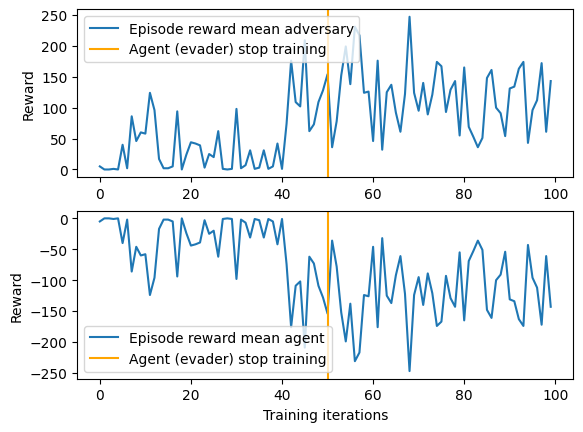

dict_keys(['adversary', 'agent'])


In [ ]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].axvline(
        x=iteration_when_stop_training_evaders,
        label="Agent (evader) stop training",
        color="orange",
    )
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()
print(env.group_map.keys())

In [ ]:
!pip3 install PyOpenGL

In [ ]:
!apt-get install python3-opengl
!pip3 install torchvision

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached triton-3.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl (906.5 MB)
Using cached triton-3.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (209.5 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the 

In [ ]:
if use_vmas and not is_sphinx:
    # Replace tmpdir with any desired path where the video should be saved
    with tempfile.TemporaryDirectory() as tmpdir:
        video_logger = CSVLogger("vmas_logs", tmpdir, video_format="mp4")
        print("Creating rendering env")
        env_with_render = TransformedEnv(env.base_env, env.transform.clone())
        env_with_render = env_with_render.append_transform(
            PixelRenderTransform(
                out_keys=["pixels"],
                # the np.ndarray has a negative stride and needs to be copied before being cast to a tensor
                preproc=lambda x: x.copy(),
                as_non_tensor=True,
                # asking for array rather than on-screen rendering
                mode="rgb_array",
            )
        )
        env_with_render = env_with_render.append_transform(
            VideoRecorder(logger=video_logger, tag="vmas_rendered")
        )
        with set_exploration_type(ExplorationType.DETERMINISTIC):
            print("Rendering rollout...")
            env_with_render.rollout(100, policy=agents_exploration_policy)
        print("Saving the video...")
        env_with_render.transform.dump()
        print("Saved! Saved directory tree:")
        video_logger.print_log_dir()

Creating rendering env
Rendering rollout...
Saving the video...


RuntimeError: operator torchvision::nms does not exist